In [14]:
import numpy as np
import matplotlib.pyplot as pt
import numpy.linalg as la
import scipy.sparse.linalg as lin
from mpl_toolkits.mplot3d import Axes3D
from scipy.interpolate import griddata
import seaborn as sns
%matplotlib inline
# %matplotlib qt

In [27]:
# When numerically solving the structure of hydrogen atom using finite difference method, 
# the main objective is to establish 1-1 correspondence between the col vector which represents coordinates:
# (000) (001)....(NNN), with the horizontal location of matrix (0,1...N^3) to put values in 
# matrix where the numbers should be calculated. 
# if we focus on certain point (x,y,z), it has a location in the col vector, and its neigbourhood(x-1,y,z)
# has various positions in the horizontal row in the matrix, and we need to find the positions, that's why we
# build the identification-table. 

L = 31 # dimension of the box
N = 20 # Accuracy; even number
location = []
for i in range(0,N):
    for j in range(0,N):
        for k in range(0,N):
            location.append((i,j,k)) # (000),001,...00N, 011,...0N1,...0NN, 100, 101....NNN
            
def matrix_to_index(a,b,c):
    return location.index((a,b,c)) # e.g (0,0,3)-> 3
def index_to_ijk(i):
    return location[i] #e.g 5->(0,0,5)

X = np.linspace(-L/2,L/2,N)
Y = np.linspace(-L/2,L/2,N)
Z = np.linspace(-L/2,L/2,N)
d = X[1]-X[0]

# Constructing Hamiltonian: -p^2/2m + V(1/r)

H=np.zeros((N**3,N**3))

for i in range(0,N**3): # loop all xyz combination
    x = index_to_ijk(i)[0]
    y = index_to_ijk(i)[1]
    z = index_to_ijk(i)[2]
    
    H[i,matrix_to_index(x,y,z)] = -6   # f''(x) = f''(x+d)-2f(x)+f''(x-d) / d^2 and sum! 
    if x+1<N:
        H[i,matrix_to_index(x+1,y,z)] = 1
    if x-1>=0:
        H[i,matrix_to_index(x-1,y,z)] = 1
    if y+1<N:
        H[i,matrix_to_index(x,y+1,z)] = 1
    if y-1>=0:
        H[i,matrix_to_index(x,y-1,z)] = 1
    if z+1<N:
        H[i,matrix_to_index(x,y,z+1)] = 1
    if z-1>=0:
        H[i,matrix_to_index(x,y,z-1)] = 1
H = -H/d**2

for i in range(0,N**3):
    x = index_to_ijk(i)[0]
    y = index_to_ijk(i)[1]
    z = index_to_ijk(i)[2]
    H[i,i] += -2/np.sqrt(X[x]**2+Y[y]**2+Z[z]**2)

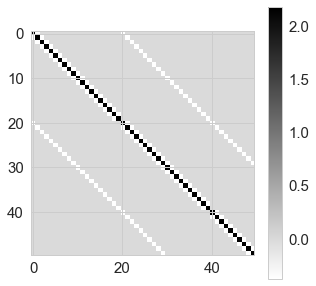

In [28]:
sns.set(font_scale=1.5)
sns.set_style("whitegrid")
pt.figure(figsize=(5,5))
pt.imshow(H[0:50,0:50],cmap='gray_r',interpolation='none')
pt.colorbar()
pt.show()

In [29]:
# Solving for eigensystem using spars matrix technique

vals, vecs = lin.eigsh(H,k=20,which='SA') # first k states with lowest energies

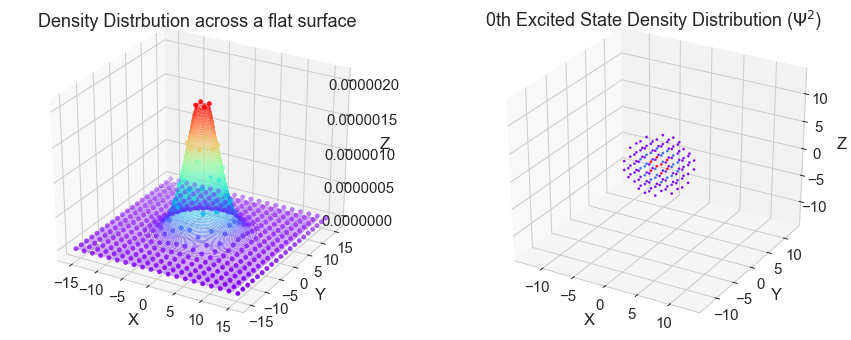

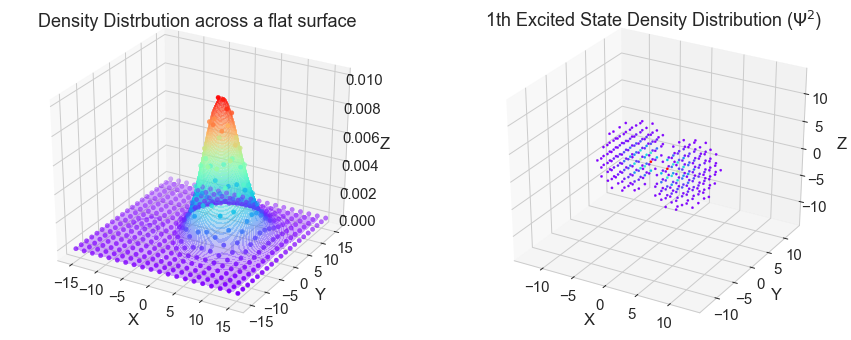

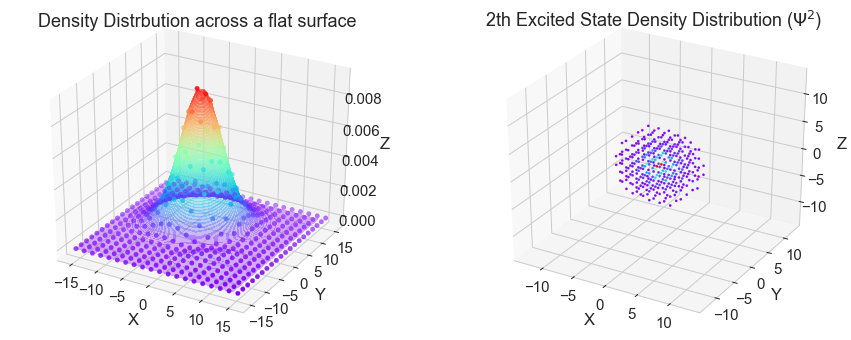

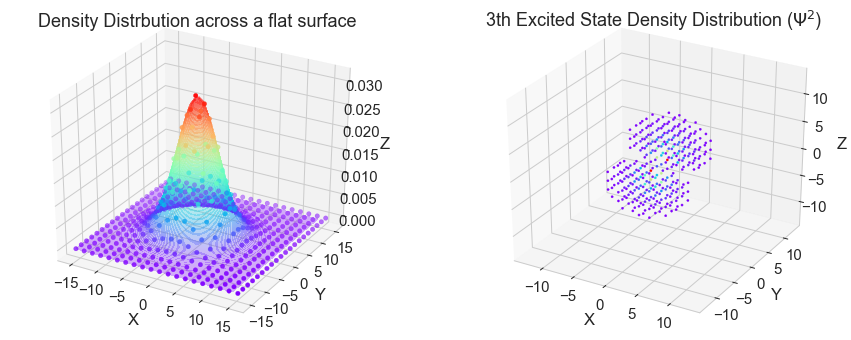

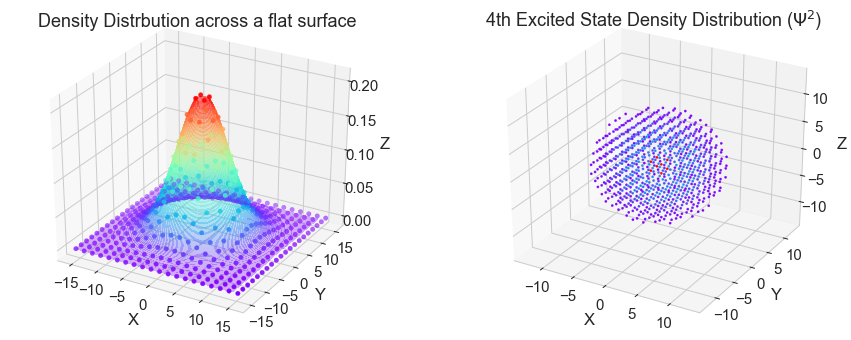

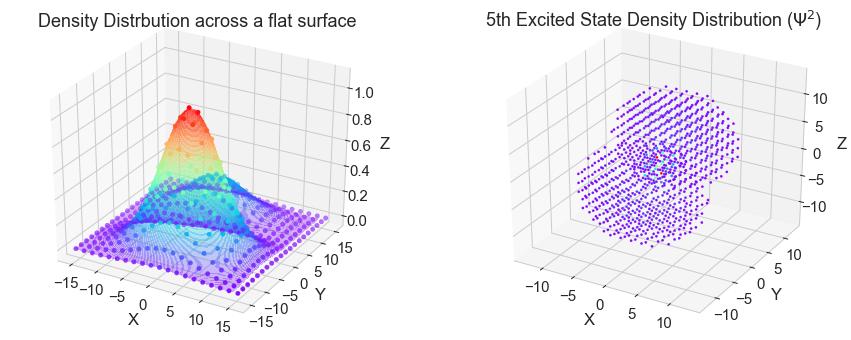

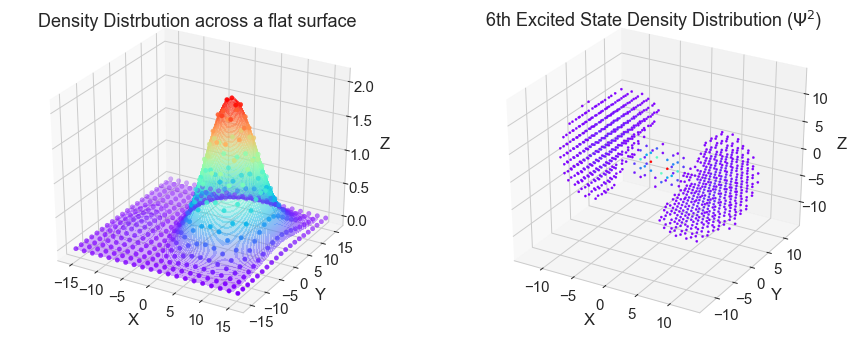

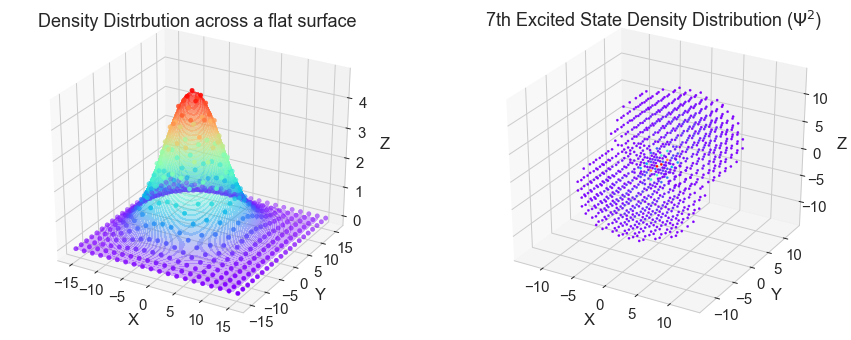

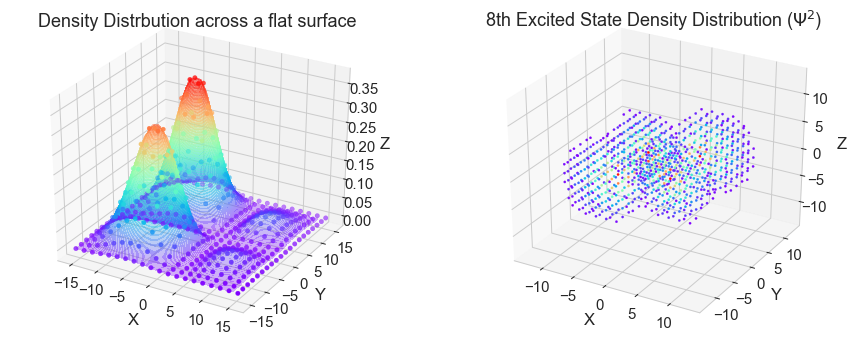

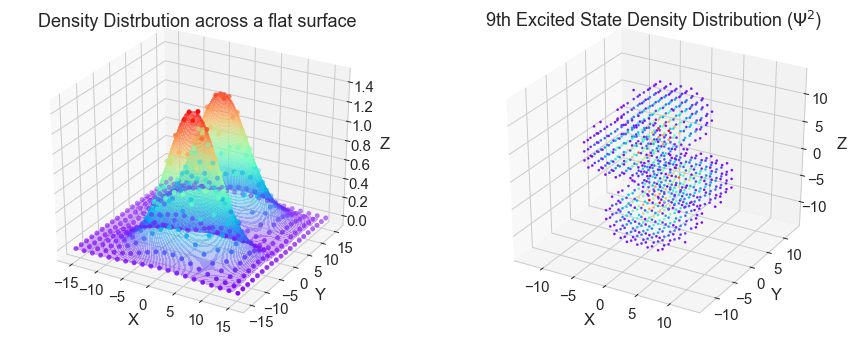

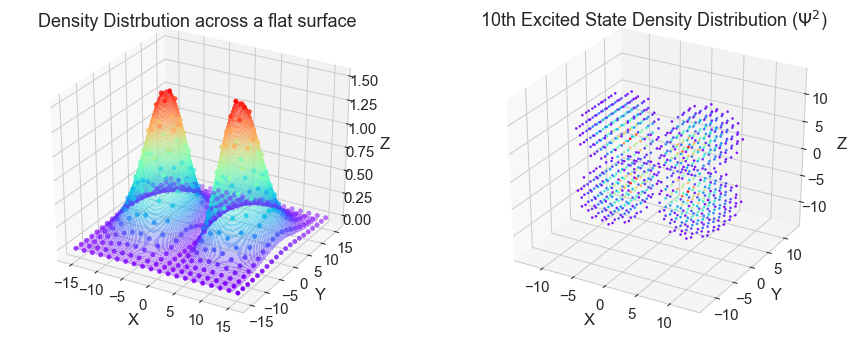

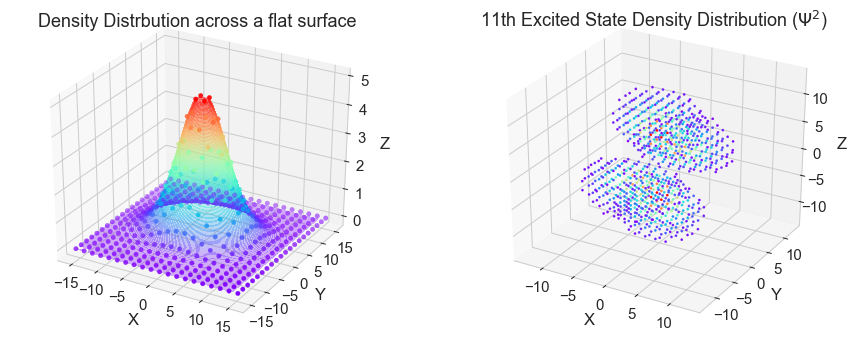

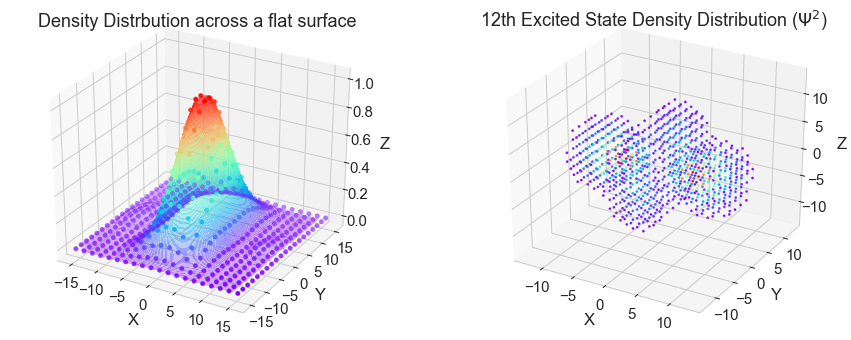

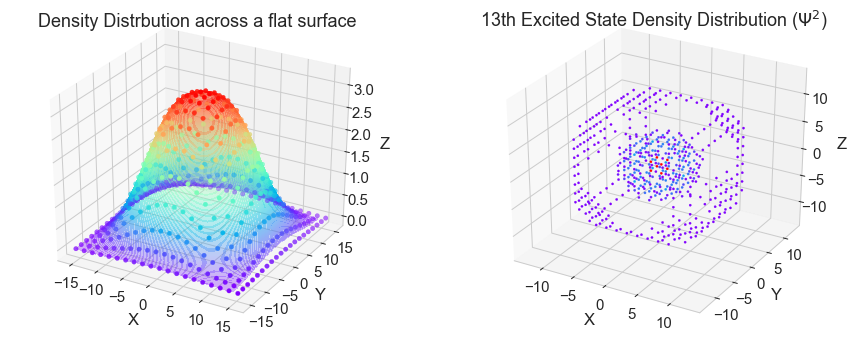

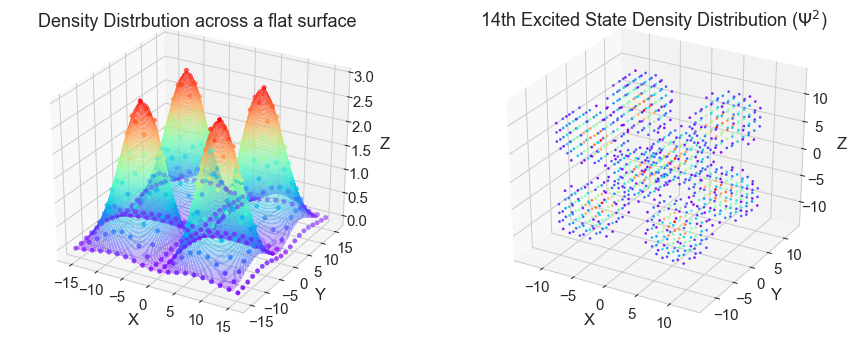

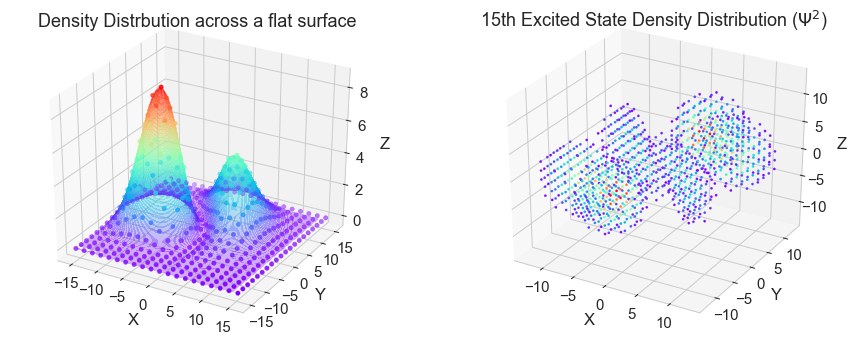

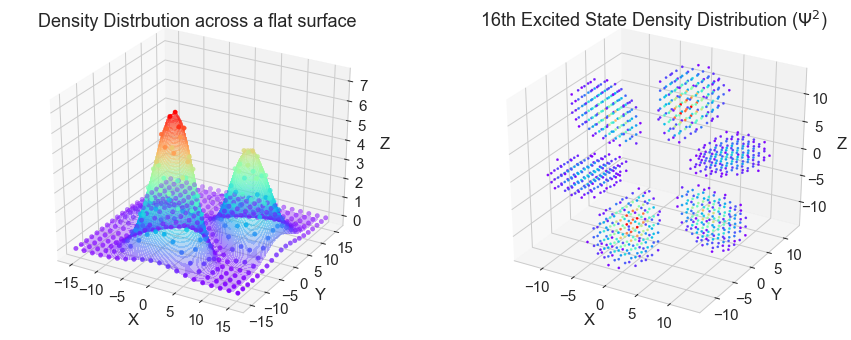

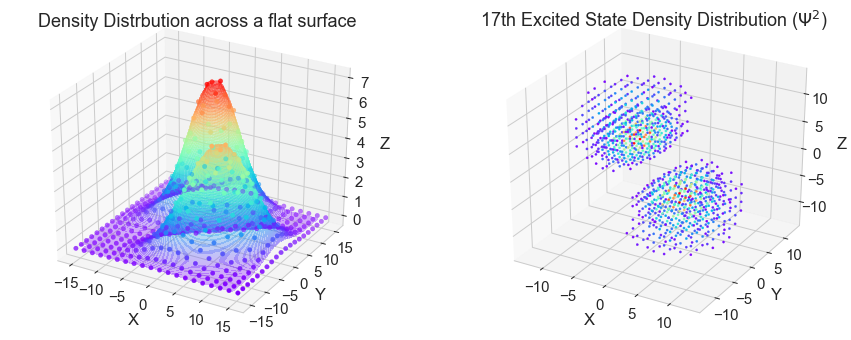

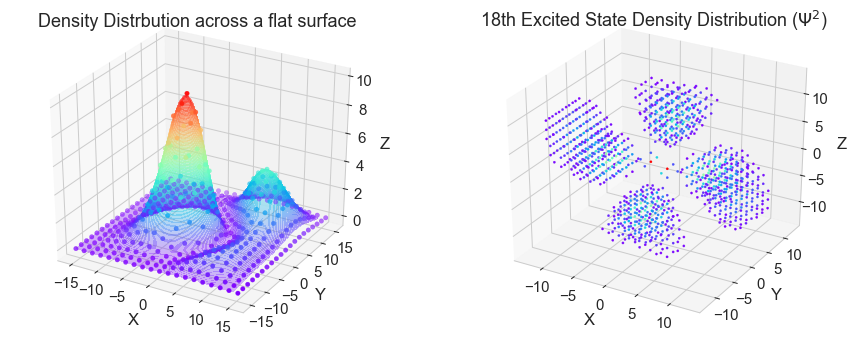

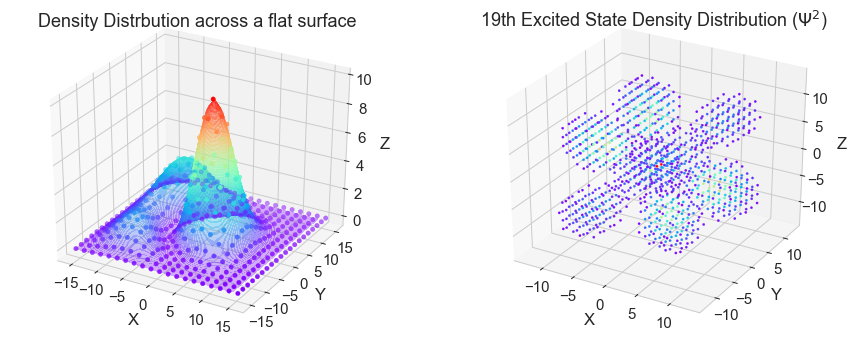

In [30]:
## Different energy states 
sns.set(font_scale=1.5)
sns.set_style("whitegrid")

for n in range(0,20):    # including ground states
    fig = pt.figure(figsize=(15,6))
    
    # Density distribution across xy plane

    ax = fig.add_subplot(121, projection='3d')
    ax.tick_params(axis='x', pad=1)
    ax.tick_params(axis='y', pad=1)
    ax.tick_params(axis='z', pad=1)
    xs=[]
    ys=[]
    rho=[]
    for i in range(0,len(vecs[:,0])):
        if index_to_ijk(i)[2]==0:
            xs.append(X[index_to_ijk(i)[0]])
            ys.append(Y[index_to_ijk(i)[1]])
            rho.append(vecs[:,n][i]**2*10**5) # *1000 to make things look nicer
            
    # interpolate
    xi = yi = np.arange(-L/2,L/2,1)
    xi,yi = np.meshgrid(xi,yi)
    zi = griddata((xs,ys),rho,(xi,yi),method='cubic')
    pt.contourf(xi,yi,zi,np.arange(0,np.max(rho),np.max(rho)/200),cmap='rainbow',alpha=0.3)
        
    ax.scatter(xs, ys, rho, c=rho, marker='o',cmap='rainbow')
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    pt.title('Density Distrbution across a flat surface')
    
    # Spacial density distribution

    ax = fig.add_subplot(122, projection='3d')
    ax.tick_params(axis='x', pad=1)
    ax.tick_params(axis='y', pad=1)
    ax.tick_params(axis='z', pad=1)
    xs=[]
    ys=[]
    zs=[]
    rho=[]
    for i in range(0,len(vecs[:,0])):
        xs = np.append(xs, X[index_to_ijk(i)[0]])
        ys = np.append(ys, Y[index_to_ijk(i)[1]])
        zs = np.append(zs, Z[index_to_ijk(i)[2]])
        rho = np.append(rho, vecs[:,n][i]**2)
    rho=np.ma.masked_where(rho < 0.0003, rho)
    
    ax.scatter(xs, ys, zs, c=rho, marker='.',alpha=1,cmap='rainbow')
    ax.set_xlim(-14,14)
    ax.set_ylim(-14,14)
    ax.set_zlim(-14,14)
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    pt.title(str(n)+'th Excited State Density Distribution ($\Psi^2$)')
    pt.show()